# Define MHWs using [Hobday definition](https://doi.org/10.1016/j.pocean.2015.12.014)
(>=5 consecutive days w/ a gap of >=3 days in between events for each grid cell)

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import linregress
from xrft import detrend
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import geopandas as gpd
import regionmask
import gsw
import time
from tqdm import tqdm
import glob
import os
from collections import defaultdict

## Plotting func

In [2]:
def cartopy_plot(da, cmap_choice, cbar_label, var_title, vmin=None, vmax=None, quiver=True):
    proj = ccrs.Mercator() #with Mercator you can put lat lon values.
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=proj))
    ax.set_extent([-98, -81, 17.5, 31], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
    # ---- infer coord names if not provided ----
    lat_candidates = ['lat', 'latitude', 'yT', 'yh']
    lon_candidates = ['lon', 'longitude', 'xT', 'xh']

    lat_name = next((c for c in lat_candidates if c in da.coords), None)
    lon_name = next((c for c in lon_candidates if c in da.coords), None)

    if lat_name is None or lon_name is None:
        raise ValueError(
            f"Could not infer lat/lon coordinates. "
            f"Found coords: {list(da.coords)}"
        )

    lats = da[lat_name]
    lons = da[lon_name]
    # -------------------------------------------------------------------------------
    
    im = ax.pcolormesh(lons, lats, da, transform=ccrs.PlateCarree(), 
                       vmin=vmin, vmax=vmax, cmap=cmap_choice)
    cb = fig.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label(fr"{cbar_label}", labelpad=8, fontsize=14)
    g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    g1.xlabels_top = False
    g1.ylabels_right = False
    plt.title(f'{var_title}', fontsize=16, y=1.07)

## OISST
Vars needed:
- detrended_intime
- threshold
- events_by_cell
- event_mask
- ex_int_oi

In [28]:
detrended_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/detrended_intime_oisstt.nc', chunks={})
ex_int_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/ex_int_oi.nc', chunks={})
threshold_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/threshold_oi.nc', chunks={})
event_mask_oi = xr.open_dataarray('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/event_mask_oi.nc', chunks={})

In [29]:
import json

with open('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/events_by_cell_oi.json', 'r') as json_file:
    events_by_cell_oi = json.load(json_file)

In [22]:
#--------------------------------------- EVENT COUNTS ------------------------------
#-----------One way to count events----------
#create empty array with correct spatial metadata
#event_count_oi = xr.zeros_like(ex_int_oi.isel({time_dim: 0}), dtype=int)

#fill with number of events per grid cell
#for cell, events in events_by_cell_oi.items():
#    cell_dict = dict(zip(('lat','lon'), cell))
#    event_count_oi.loc[cell_dict] = len(events)

#-----------Use this to count events----------
# create empty array to get spatial and meta data
event_count = xr.zeros_like(ex_int_oi.isel(time=0), dtype=int) #da of 0s
#for key (lat/lon), events (start/stop indices) in da dictionary:
#empty_da.loc[dict((lat, lon))] = len(all events in that grid cell)
for cell_str, events in events_by_cell_oi.items(): #items are the lat/lon pairs
    lat, lon = map(float, cell_str.strip("()").split(","))
    event_count.loc[dict(lat=lat, lon=lon)] = len(events)

#--------------------------------------- TOTAL MHW DAYS ------------------------------
total_mhw_days = event_mask_oi.sum(dim="time")

#--------------------------------------- DURATION ------------------------------
records = []
for cell_str, events in events_by_cell_oi.items():
    lat, lon = map(float, cell_str.strip("()").split(","))
    for i, (start, end) in enumerate(events):
        records.append({"lat": lat, "lon": lon, "event": i, "duration": end - start + 1})

df = pd.DataFrame(records)
duration_da = (df.set_index(["lat", "lon", "event"]).to_xarray())["duration"]

mean_duration = duration_da.mean(dim="event")
median_duration = duration_da.median(dim="event")
max_duration = duration_da.max(dim="event")

#--------------------------------------- MHW Temperatures ------------------------------
mhw_events = detrended_oi.where(event_mask_oi)
mean_mhw_temp = mhw_events.mean(dim="time")

#--------------------------------------- Frequency ------------------------------
years = detrended_oi.time.dt.year.values
nyears = np.unique(years).size #total time period
event_freq = event_count / nyears

#--------------------------------------- Intensity ------------------------------
mhw_intensity = (mhw_events - threshold_oi).mean(dim="time")

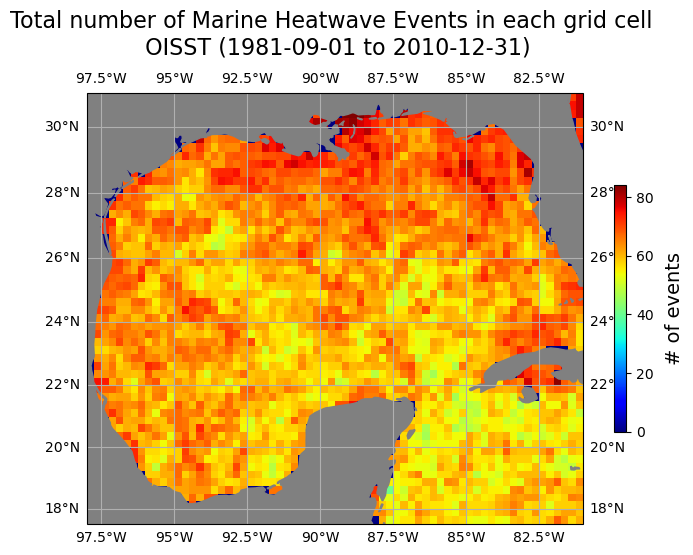

In [37]:
cartopy_plot(event_count, 'jet', '# of events', 
             'Total number of Marine Heatwave Events in each grid cell \n OISST (1981-09-01 to 2010-12-31)')

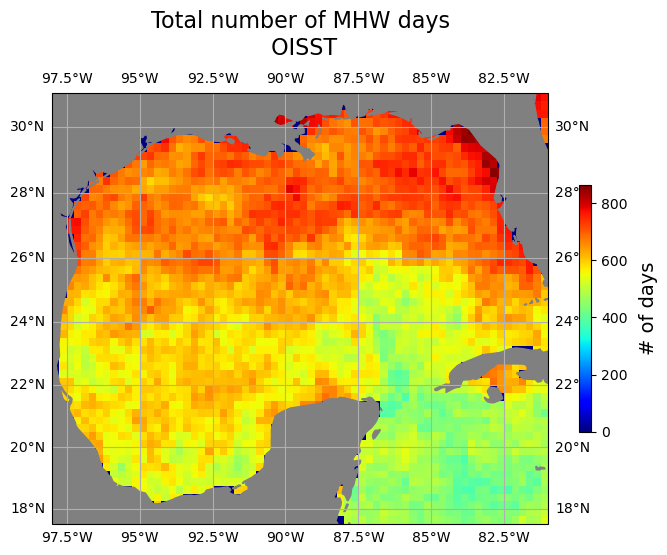

In [26]:
cartopy_plot(total_mhw_days, 'jet', '# of days', 
             'Total number of MHW days\n OISST');#if time res is daily


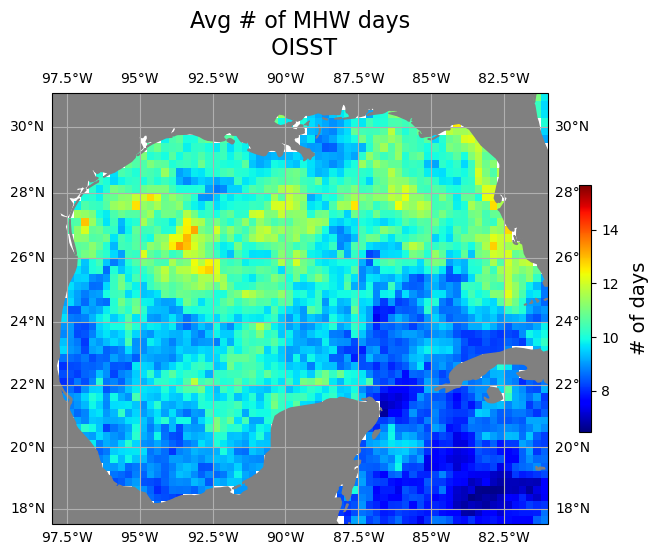

In [27]:
cartopy_plot(mean_duration, 'jet', '# of days', 
             'Avg # of MHW days\n OISST')#,vmin=0, vmax=14,);#if time res is daily


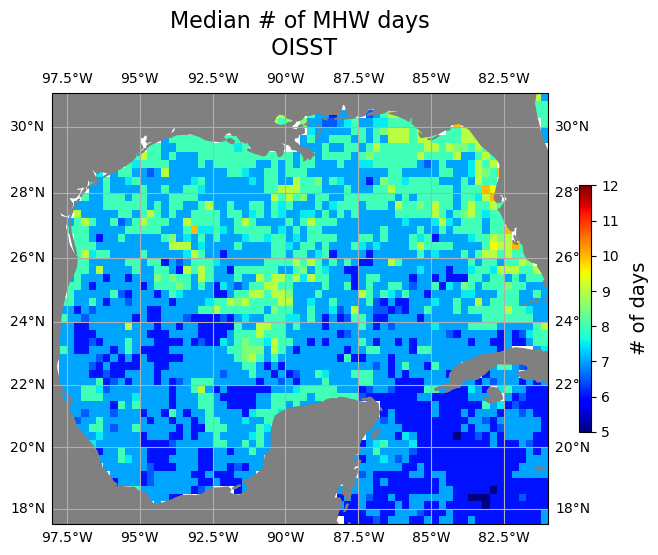

In [28]:
cartopy_plot(median_duration, 'jet', '# of days', 
             'Median # of MHW days\n OISST');#if time res is daily


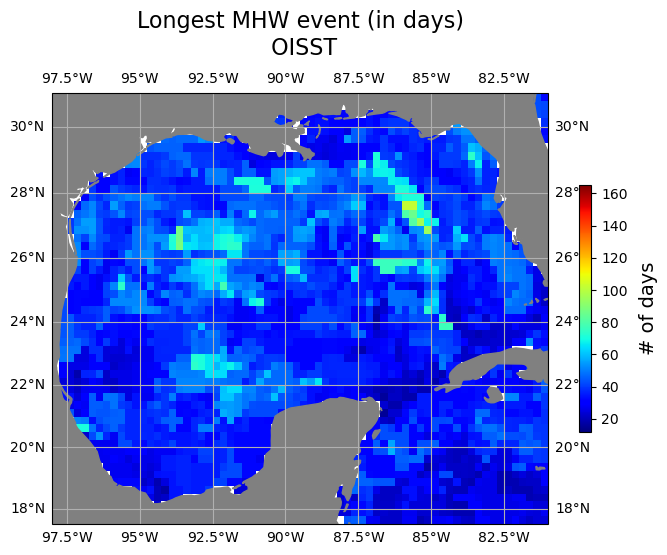

In [29]:
cartopy_plot(max_duration, 'jet', '# of days', 
             'Longest MHW event (in days)\n OISST');#if time res is daily


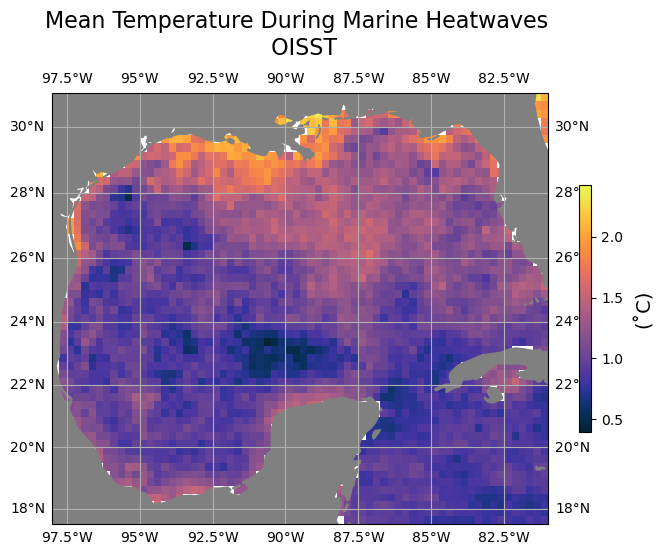

In [30]:
cartopy_plot(mean_mhw_temp, cmocean.cm.thermal, '(˚C)', 
             'Mean Temperature During Marine Heatwaves \n OISST',);

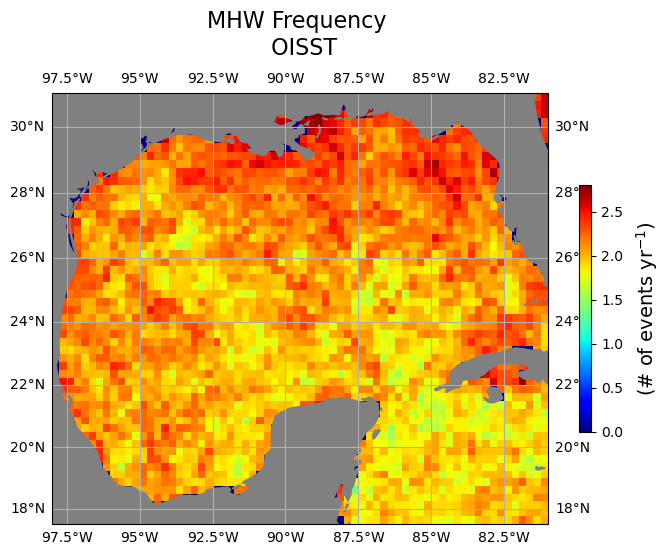

In [31]:
cartopy_plot(event_freq, 'jet', r'(# of events yr$^{-1}$)', 'MHW Frequency \n OISST');

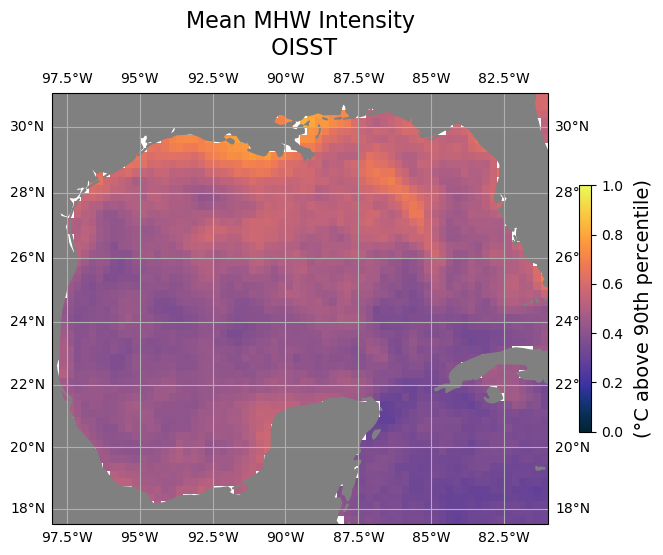

In [48]:
cartopy_plot(mhw_intensity, cmocean.cm.thermal, '(°C above 90th percentile)', 
             'Mean MHW Intensity\n OISST', vmin=0, vmax=1); 

In [41]:
event_count.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/event_count_oi.nc')

In [42]:
total_mhw_days.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/total_mhw_days_oi.nc')

In [44]:
mean_duration.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mean_duration_oi.nc')

In [45]:
median_duration.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/median_duration_oi.nc')

In [46]:
max_duration.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/max_duration_oi.nc')

In [47]:
mean_mhw_temp.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mean_mhw_temp_oi.nc')

In [49]:
event_freq.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/event_freq_oi.nc')

In [50]:
mhw_intensity.to_netcdf('/work5/stb/MHW-gfdl/SPEAR/vars/OISST/map_vars/mhw_intensity_oi.nc')

## SPEAR-LO

In [3]:
#detrended SSTs
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/detrended/detrended_intime_spear_lo*.nc'))
detrended_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'SST_ens{ens}')
    detrended_splo.append(da)

In [4]:
#darr of 1s/0s of SSTs>90th percentile
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/ex_int_splo*.nc'))
ex_int_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'{ens}')
    ex_int_splo.append(da)

In [5]:
#darr of 90th percentile SSTs
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/exceedance/threshold_splo*.nc'))
threshold_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'{ens}')
    threshold_splo.append(da)

In [6]:
#darr following criteria (>=90th, >=5 consec days, >=3 day gaps)
files = sorted(glob.glob('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/events/event_mask_splo*.nc'))
event_mask_splo = []
for f in files:
    ds = xr.open_dataset(f, chunks={})
    da = next(iter(ds.data_vars.values()))
    #take the # in filename and add it to darr name
    ens = os.path.basename(f).split('_lo')[-1].split('.nc')[0] 
    da = da.rename(f'{ens}')
    event_mask_splo.append(da)

In [7]:
event_mask_splo

[<xarray.DataArray 'event_mask_splo01' (time: 10714, yT: 26, xT: 83)> Size: 23MB
 dask.array<open_dataset-__xarray_dataarray_variable__, shape=(10714, 26, 83), dtype=bool, chunksize=(10714, 26, 83), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) object 86kB 1981-09-01 12:00:00 ... 2010-12-31 12:00:00
   * xT         (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT         (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
     quantile   float64 8B ...
     dayofyear  (time) int64 86kB dask.array<chunksize=(10714,), meta=np.ndarray>,
 <xarray.DataArray 'event_mask_splo02' (time: 10714, yT: 26, xT: 83)> Size: 23MB
 dask.array<open_dataset-__xarray_dataarray_variable__, shape=(10714, 26, 83), dtype=bool, chunksize=(10714, 26, 83), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) object 86kB 1981-09-01 12:00:00 ... 2010-12-31 12:00:00
   * xT         (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT      

In [8]:
with open('/work5/stb/MHW-gfdl/SPEAR/vars/SPEAR-LO/events/events_by_cell_splo.json', 'r') as json_file:
    events_by_cell_splo = json.load(json_file)

In [70]:
%%time
#--------------------------------------- EVENT COUNTS <2min ------------------------------
event_counts_splo = []

for da, events_by_cell in zip(ex_int_splo, events_by_cell_splo):
    # create empty event-count array for this DA
    event_count = xr.zeros_like(da.isel(time=0), dtype=int).rename(f'event_count_ens{da.name[-2:]}')
    # fill it using the corresponding dictionary
    for cell_str, events in events_by_cell.items():
        lat, lon = map(float, cell_str.strip("()").split(","))
        event_count.loc[dict(yT=lat, xT=lon)] = len(events)

    event_counts_splo.append(event_count)

CPU times: user 1min 7s, sys: 212 ms, total: 1min 7s
Wall time: 1min 7s


In [48]:
event_counts_splo

[<xarray.DataArray 'event_count_ens01' (yT: 26, xT: 83)> Size: 17kB
 dask.array<setitem, shape=(26, 83), dtype=int64, chunksize=(26, 83), chunktype=numpy.ndarray>
 Coordinates:
     time       object 8B 1981-09-01 12:00:00
   * xT         (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT         (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
     quantile   float64 8B ...
     dayofyear  int64 8B dask.array<chunksize=(), meta=np.ndarray>,
 <xarray.DataArray 'event_count_ens02' (yT: 26, xT: 83)> Size: 17kB
 dask.array<setitem, shape=(26, 83), dtype=int64, chunksize=(26, 83), chunktype=numpy.ndarray>
 Coordinates:
     time       object 8B 1981-09-01 12:00:00
   * xT         (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT         (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
     quantile   float64 8B ...
     dayofyear  int64 8B dask.array<chunksize=(), meta=np.ndarray>,
 <xarray.DataArray 'event_count_ens03'

In [71]:
%%time
#--------------------------------------- TOTAL MHW DAYS <1min ------------------------------
total_mhw_days = []
for da in event_mask_splo:
    total_mhw_days.append(da.sum(dim="time"))

CPU times: user 50.6 ms, sys: 1.99 ms, total: 52.6 ms
Wall time: 52 ms


In [52]:
total_mhw_days

[<xarray.DataArray 'event_mask_splo01' (yT: 26, xT: 83)> Size: 17kB
 dask.array<sum-aggregate, shape=(26, 83), dtype=int64, chunksize=(26, 83), chunktype=numpy.ndarray>
 Coordinates:
   * xT        (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT        (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
     quantile  float64 8B ...,
 <xarray.DataArray 'event_mask_splo02' (yT: 26, xT: 83)> Size: 17kB
 dask.array<sum-aggregate, shape=(26, 83), dtype=int64, chunksize=(26, 83), chunktype=numpy.ndarray>
 Coordinates:
   * xT        (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
   * yT        (yT) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
     quantile  float64 8B ...,
 <xarray.DataArray 'event_mask_splo03' (yT: 26, xT: 83)> Size: 17kB
 dask.array<sum-aggregate, shape=(26, 83), dtype=int64, chunksize=(26, 83), chunktype=numpy.ndarray>
 Coordinates:
   * xT        (xT) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -1

In [46]:
len(events_by_cell_splo)

30

In [9]:
%%time
#--------------------------------------- DURATION <10 sec (xr method) ------------------------------
# Get all unique cells from the first ensemble member
cells = list(events_by_cell_splo[0].keys())
lats, lons = zip(*(map(float, c.strip("()").split(",")) for c in cells))

# Convert to sorted unique lat/lon for grid
unique_lats = np.unique(lats)
unique_lons = np.unique(lons)

# Create mapping from cell string to grid indices
lat_idx = {lat: i for i, lat in enumerate(unique_lats)}
lon_idx = {lon: i for i, lon in enumerate(unique_lons)}

# Dimensions
n_ens = len(events_by_cell_splo)
n_lat = len(unique_lats)
n_lon = len(unique_lons)
max_events = max(len(events) for member in events_by_cell_splo for events in member.values())

# Preallocate array: ensemble × lat × lon × event
data = np.full((n_ens, n_lat, n_lon, max_events), np.nan)

# Fill the array
for ei, member in enumerate(events_by_cell_splo):
    for cell_str, events in member.items():
        lat, lon = map(float, cell_str.strip("()").split(","))
        li, lj = lat_idx[lat], lon_idx[lon]
        durations = [end - start + 1 for start, end in events]
        data[ei, li, lj, :len(durations)] = durations

# Create xarray DataArray
duration_da = xr.DataArray(data, dims=["ensemble", "lat", "lon", "event"],
                           coords={"ensemble": np.arange(n_ens), "lat": unique_lats, "lon": unique_lons})

# Compute per-cell statistics over events
mean_duration = duration_da.mean(dim="event", skipna=True)
median_duration = duration_da.median(dim="event", skipna=True)
max_duration = duration_da.max(dim="event", skipna=True)

# Compute statistics across ensembles
mean_duration_across_ensemble = mean_duration.mean(dim="ensemble")
median_duration_across_ensemble = median_duration.median(dim="ensemble")
max_duration_across_ensemble = max_duration.max(dim="ensemble")

CPU times: user 8.77 s, sys: 219 ms, total: 8.99 s
Wall time: 8.39 s


In [10]:
n_ens

30

In [11]:
duration_da

<xarray.DataArray (ensemble: 30, lat: 26, lon: 83, event: 92)> Size: 48MB
array([[[[ 12.,  31.,   5., ...,  nan,  nan,  nan],
         [ 12.,  29.,   5., ...,  nan,  nan,  nan],
         [ 27.,   8.,  13., ...,  nan,  nan,  nan],
         ...,
         [  5.,   9.,   5., ...,  nan,  nan,  nan],
         [  5.,   8.,   5., ...,  nan,  nan,  nan],
         [ 10.,   8.,   5., ...,  nan,  nan,  nan]],

        [[  9.,   5.,  26., ...,  nan,  nan,  nan],
         [ 12.,  26.,  10., ...,  nan,  nan,  nan],
         [ 25.,   7.,  10., ...,  nan,  nan,  nan],
         ...,
         [  5.,   9.,   5., ...,  nan,  nan,  nan],
         [  5.,   9.,   6., ...,  nan,  nan,  nan],
         [  5.,   8.,   5., ...,  nan,  nan,  nan]],

        [[ 17.,   5.,   7., ...,  nan,  nan,  nan],
         [ 17.,   6.,  10., ...,  nan,  nan,  nan],
         [ 23.,   9.,  12., ...,  nan,  nan,  nan],
         ...,
...
         ...,
         [  5.,  39.,  16., ...,  nan,  nan,  nan],
         [  5.,  14.,  33., ...,  nan,  nan,  nan],
         [ 34.,  30.,  16., ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [  7.,  65.,  14., ...,  nan,  nan,  nan],
         [  8.,  63.,  13., ...,  nan,  nan,  nan],
         [  5.,  15.,   5., ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ 98.,  19.,   6., ...,  nan,  nan,  nan],
         [ 90.,  19.,   6., ...,  nan,  nan,  nan],
         [ 15.,  66.,  18., ...,  nan,  nan,  nan]]]])
Coordinates:
  * ensemble  (ensemble) int64 240B 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
  * lat       (lat) float64 208B 10.2 10.67 11.22 11.85 ... 29.59 30.46 31.31
  * lon       (lon) float64 664B -98.5 -97.5 -96.5 -95.5 ... -18.5 -17.5 -16.5
Dimensions without coordinates: event

In [69]:
%%time 
#--------------------------------------- MHW Temperatures <2sec ------------------------------mhw_events = []
mean_mhw_temp = []
for da, mask in zip(detrended_splo, event_mask_splo):
    mhw = da.where(mask)
    mean_temp = mhw.mean(dim="time")
    
    mhw_events.append(mhw)
    mean_mhw_temp.append(mean_temp)

CPU times: user 1.03 s, sys: 9.03 ms, total: 1.04 s
Wall time: 1.04 s


In [57]:
%%time
#--------------------------------------- Frequency <1sec ------------------------------
years = detrended_splo[0].time.dt.year.values
nyears = np.unique(years).size #total time period
# compute event frequency for all ensemble members
event_freq_splo = [da_events / nyears for da_events in event_counts_splo]

CPU times: user 49 ms, sys: 994 μs, total: 50 ms
Wall time: 49.5 ms


In [84]:
%%time
#--------------------------------------- Intensity <1sec------------------------------
mhw_intensity_splo = []
for mhws, thresh in zip(mhw_events, threshold_splo):
    intensity = (mhws - thresh).mean(dim="time").rename(f'intensity_ens{mhws.name[-2:]}')
    mhw_intensity_splo.append(intensity)

CPU times: user 605 ms, sys: 21.9 ms, total: 627 ms
Wall time: 629 ms


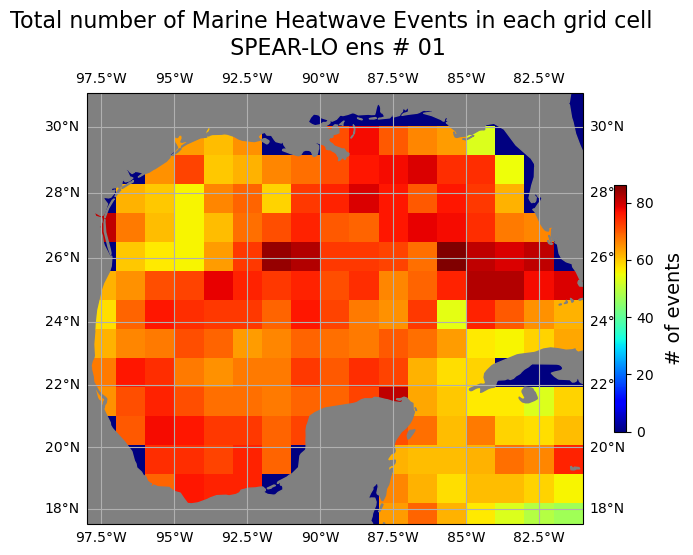

In [76]:
cartopy_plot(event_counts_splo[0], 'jet', '# of events', 
    f'Total number of Marine Heatwave Events in each grid cell \n SPEAR-LO ens # {event_counts_splo[0].name[-2:]}')

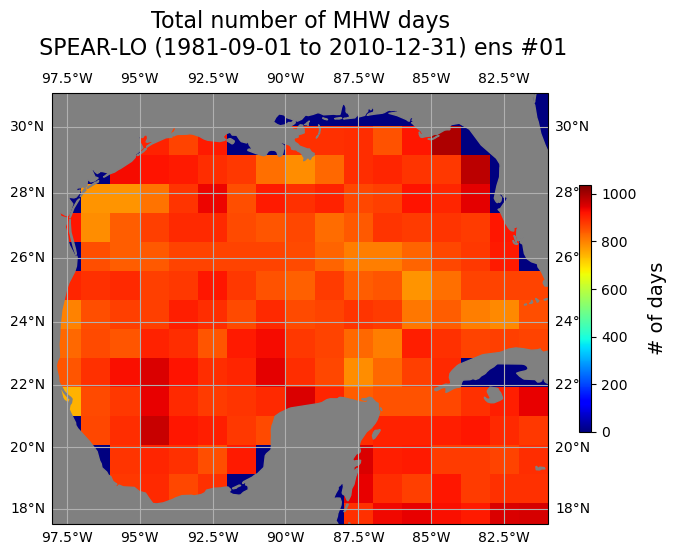

In [72]:
cartopy_plot(total_mhw_days[0], 'jet', '# of days', 
    f'Total number of MHW days\n SPEAR-LO (1981-09-01 to 2010-12-31) ens #{total_mhw_days[0].name[-2:]}');

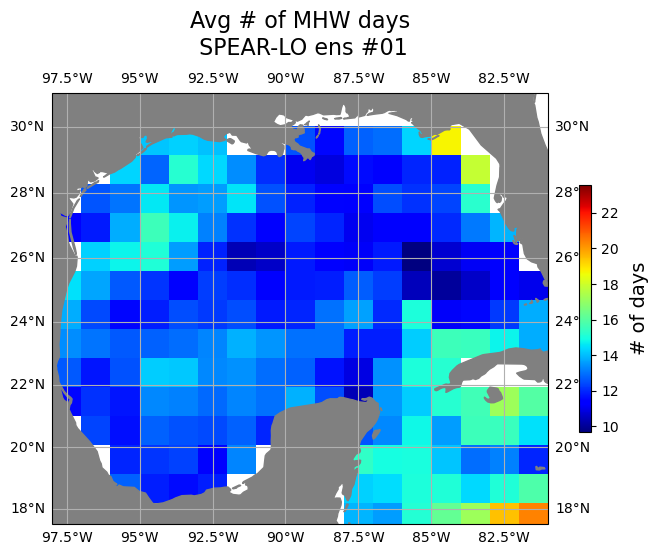

In [12]:
cartopy_plot(mean_duration[0], 'jet', '# of days', 'Avg # of MHW days\n SPEAR-LO ens #01')

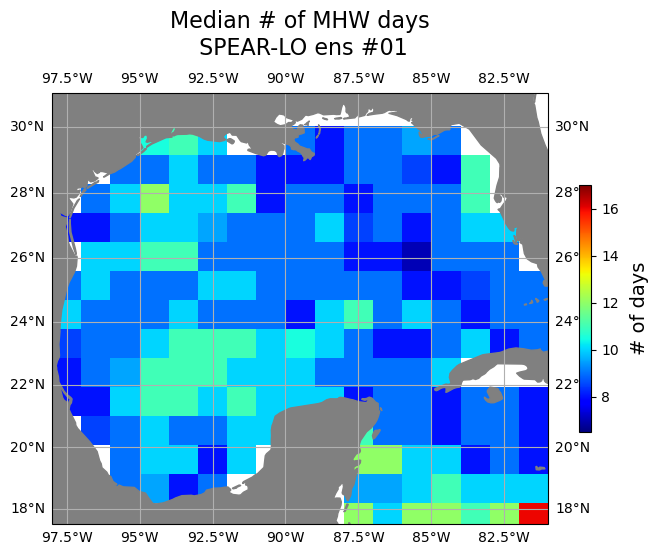

In [16]:
cartopy_plot(median_duration[0], 'jet', '# of days', 
             'Median # of MHW days\n SPEAR-LO ens #01');#if time res is daily


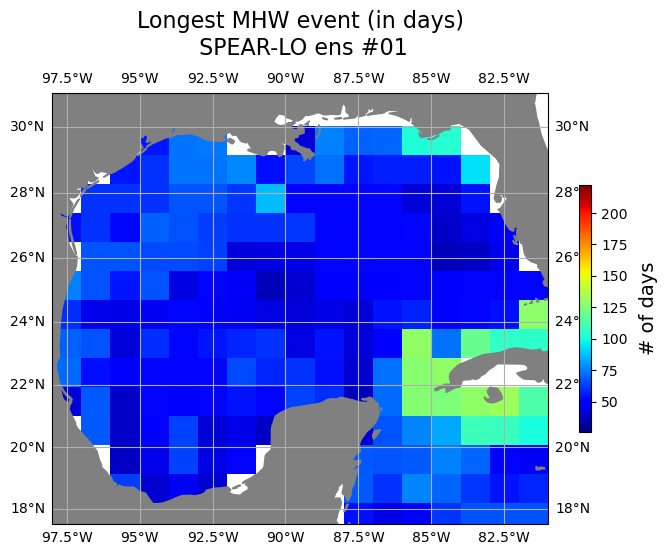

In [17]:
cartopy_plot(max_duration[0], 'jet', '# of days', 
             'Longest MHW event (in days)\n SPEAR-LO ens #01');#if time res is daily


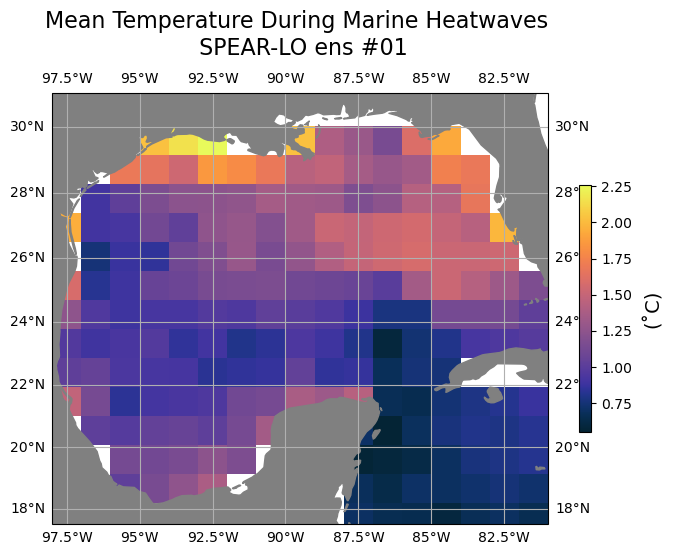

In [77]:
cartopy_plot(mean_mhw_temp[0], cmocean.cm.thermal, '(˚C)', 
    f'Mean Temperature During Marine Heatwaves \n SPEAR-LO ens #{mean_mhw_temp[0].name[-2:]}',);

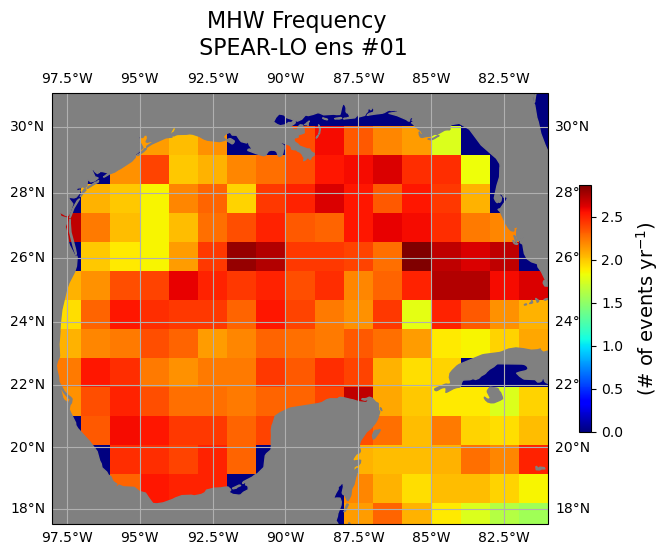

In [79]:
cartopy_plot(event_freq_splo[0], 'jet', r'(# of events yr$^{-1}$)', 
             f'MHW Frequency \n SPEAR-LO ens #{event_freq_splo[0].name[-2:]}');

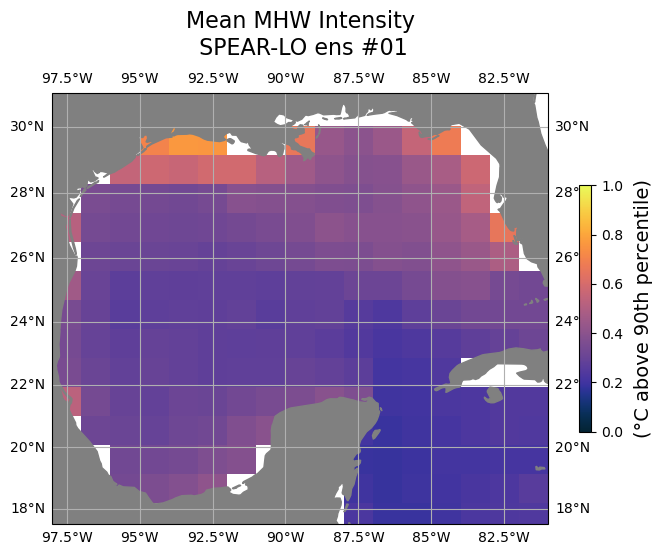

In [85]:
cartopy_plot(mhw_intensity_splo[0], cmocean.cm.thermal, '(°C above 90th percentile)', 
    f'Mean MHW Intensity\n SPEAR-LO ens #{mhw_intensity_splo[0].name[-2:]}', vmin=0, vmax=1); 

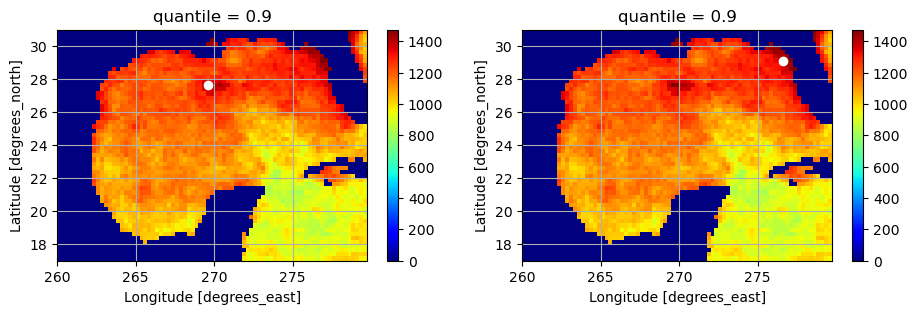

In [53]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
total_mhw_days.plot(cmap='jet', ax=ax0)
ax0.grid()
ax0.plot(269.625, 27.625, 'wo')

total_mhw_days.plot(cmap='jet', ax=ax1)
ax1.grid()
ax1.plot(276.625, 29.125, 'wo');

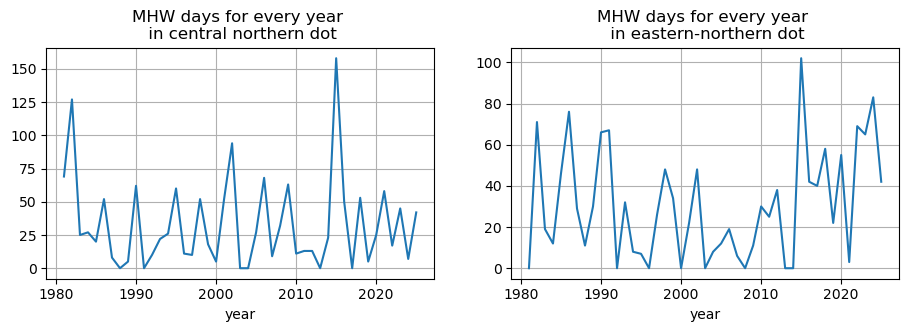

In [55]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11, 3))
event_mask.sel(lat=27.625, lon=269.625).groupby('time.year').sum('time').plot(ax=ax0)
ax0.grid()
ax0.set_title('MHW days for every year \n in central northern dot')
event_mask.sel(lat=29.125, lon=276.625).groupby('time.year').sum('time').plot(ax=ax1)
ax1.grid()
ax1.set_title('MHW days for every year \n in eastern-northern dot');

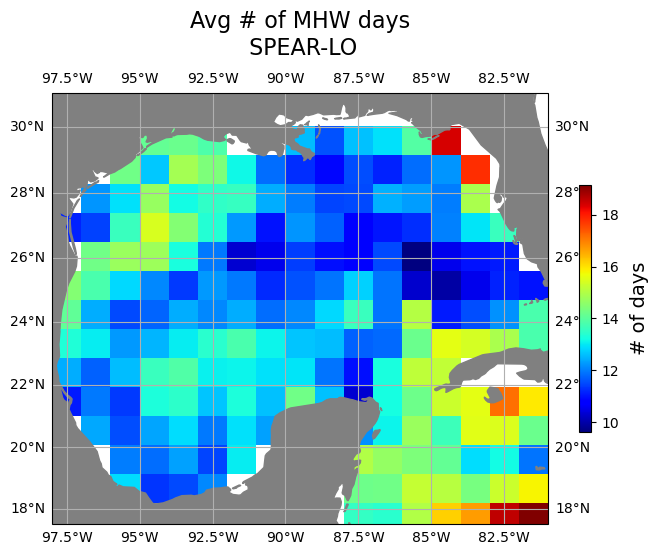

In [33]:
cartopy_plot(mean_duration, 'xT', 'yT', 'jet', '# of days', 
             'Avg # of MHW days\n SPEAR-LO')#,vmin=0, vmax=14,);#if time res is daily


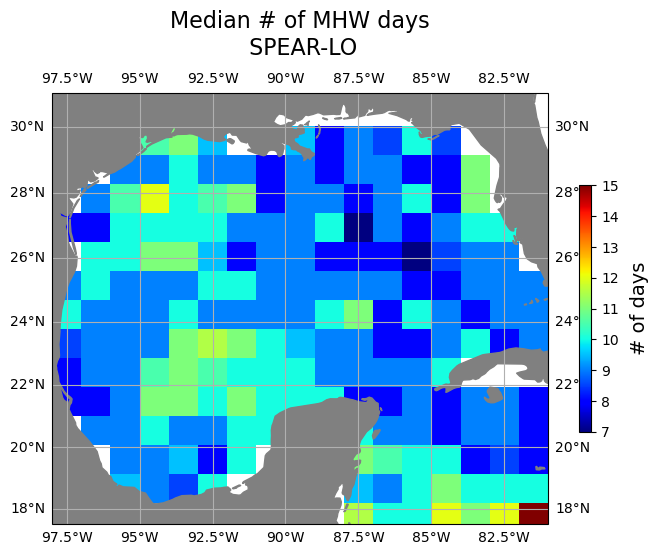

In [34]:
cartopy_plot(median_duration, 'xT', 'yT', 'jet', '# of days', 
             'Median # of MHW days\n SPEAR-LO');#if time res is daily


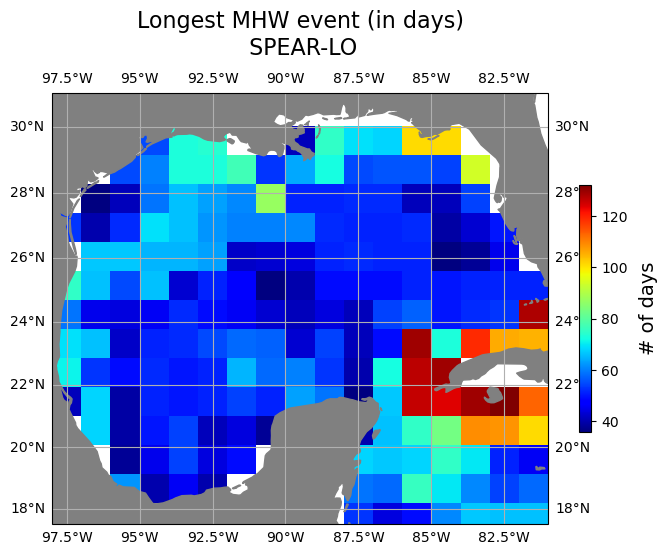

In [35]:
cartopy_plot(max_duration, 'xT', 'yT', 'jet', '# of days', 
             'Longest MHW event (in days)\n SPEAR-LO');#if time res is daily


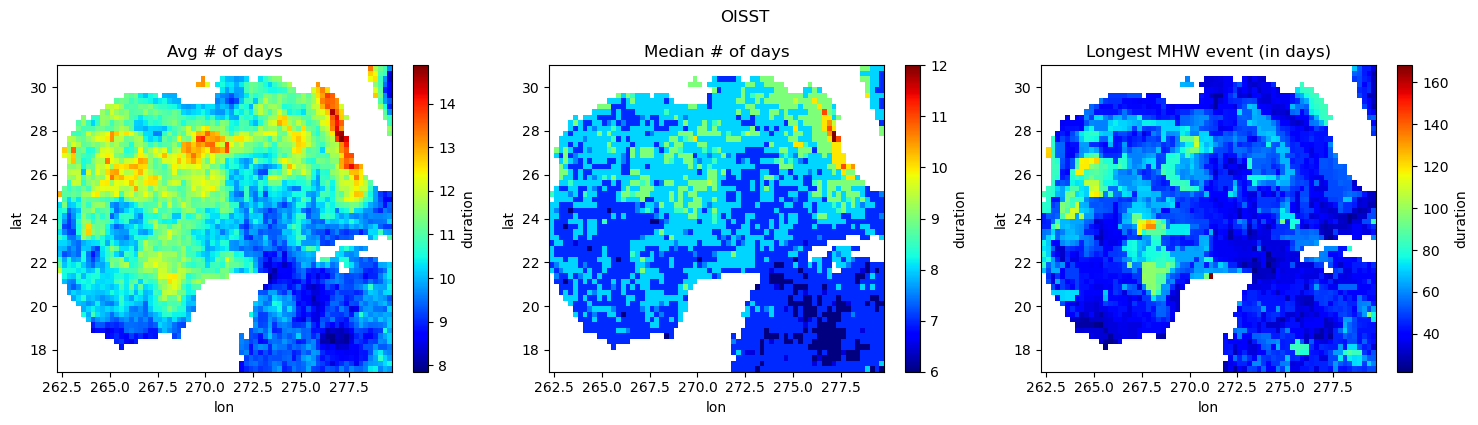

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
mean_duration.plot(ax=ax[0], cmap='jet')
ax[0].set_title('Avg # of days')
median_duration.plot(ax=ax[1], cmap='jet')
ax[1].set_title('Median # of days')
max_duration.plot(ax=ax[2], cmap='jet')
ax[2].set_title('Longest MHW event (in days)')
plt.tight_layout()
plt.suptitle('OISST', y=1.05);

## BIAS MAPS
(Take difference between `OISST` and `SPEAR-LO`)